In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# settings
plt.rcParams['figure.figsize'] = [10, 5]

In [48]:
# import numerical integration
from scipy.integrate import cumulative_trapezoid
# import own python functions
%run ../test/hemispherical_electrode.py # as example
%run ../ec_tools/semi_integration/G1.py 

# Semiintegration documentation

Here we firstly introduce the mathematical understanding of the semi-operators and the link to the voltammograms. Afterwards we setup a simple steady-state voltammogram and presents some methods for the semiintegration. These methods will be then applyed on the voltammogram and compare them with a numerical integral.

These methods are (unless otherwise stated) based from Oldham: *Electrochemical Science and Technology, 2012*, including its web resources: $\texttt{Web1244}$,  $\texttt{Web1245}$. 

## Content

**1** Steady-State Voltammogram\
**2** Semi-Operations\
**3** Semiintegration Methods\
**3.1** Grünwald Algorithms\
**3.2** RL Algorithms

## 1 Steady-State Voltammogram
Let's first start with an examplary steady-state voltammetry at hemispherical microelectrode (derived in Oldham, Electrochemical Science and Technology, 2012), which is defined by:
$$
\begin{align}
I(t) = \frac{2 \pi FD_RD_Oc^b_R r_{hemi}}{D_O + D_R \exp\left\{-F\left[ E(t) -E^{o'}\right]/RT\right\}}
\end{align}
$$
With:
* $D_R$: Diffusion coefficient of reduced specimen (in $m^2/s$)
* $D_O$: Diffusion coefficient of oxidized specimen (in $m^2/s$)
* $c^b_R$: bulk concentration of reduced specimen (in $mol/m^3$)
* $r_{hemi}$: radius of hemispherical electrode (in $m$)
* $E(t)$: time-dependend potential (in $V$)

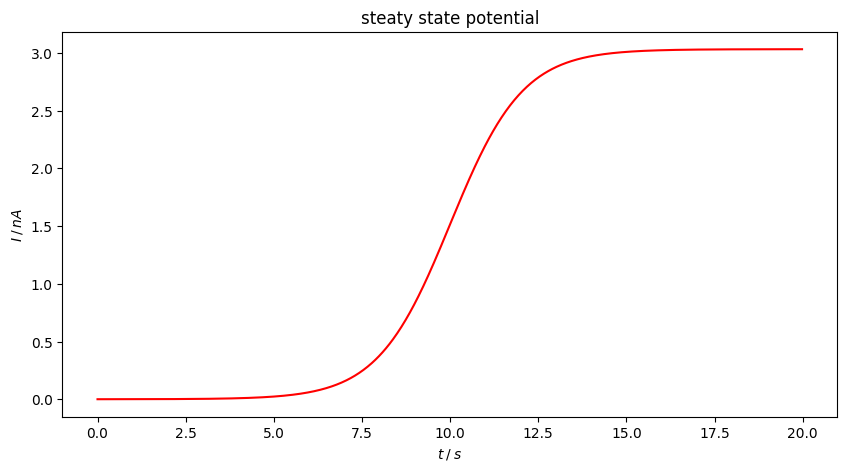

In [5]:
N_max = 1000;   # No. of time intervals

# calculate potential
[t,I] = current_hemispherical1(N_max =N_max); # with default values

# Plot the current for different scan rates
plt.plot(t,I,'r')
plt.ylabel('$I\: / \:nA$')
plt.xlabel('$t\: / \:s$')
plt.title('steaty state potential')
plt.show()

# 2 Semi-Operations

The differentiation and the integration are common mathematical operations. The differentiation of an arbitrary function is often expressed by:

$$
\begin{align}
\frac{d}{dt} f(x)
\end{align}
$$

Interestingly, the integration can also be expressed in a similar way:
$$
\begin{align}
\frac{d^{-1}}{dt^{-1}} f(x) = \int_0^t f(\tau) d\tau
\end{align}
$$

Therefore we can express these operations in a more general way by:

$$
\begin{align}
\frac{d^{v}}{dt^{v}} f(x) = \int_0^t f(\tau) d\tau
\end{align}
$$

With:
* $v= 1$: Differentiation 
* $v=-1$: Integration

In order to that we introduce the so-called **semi-operators**, where for $v=1/2$ we have the seimidifferentiation and (more interestingly for us) with $v=-1/2$ the seimiintegration. The following picture explains the similarities of the operators to each other.


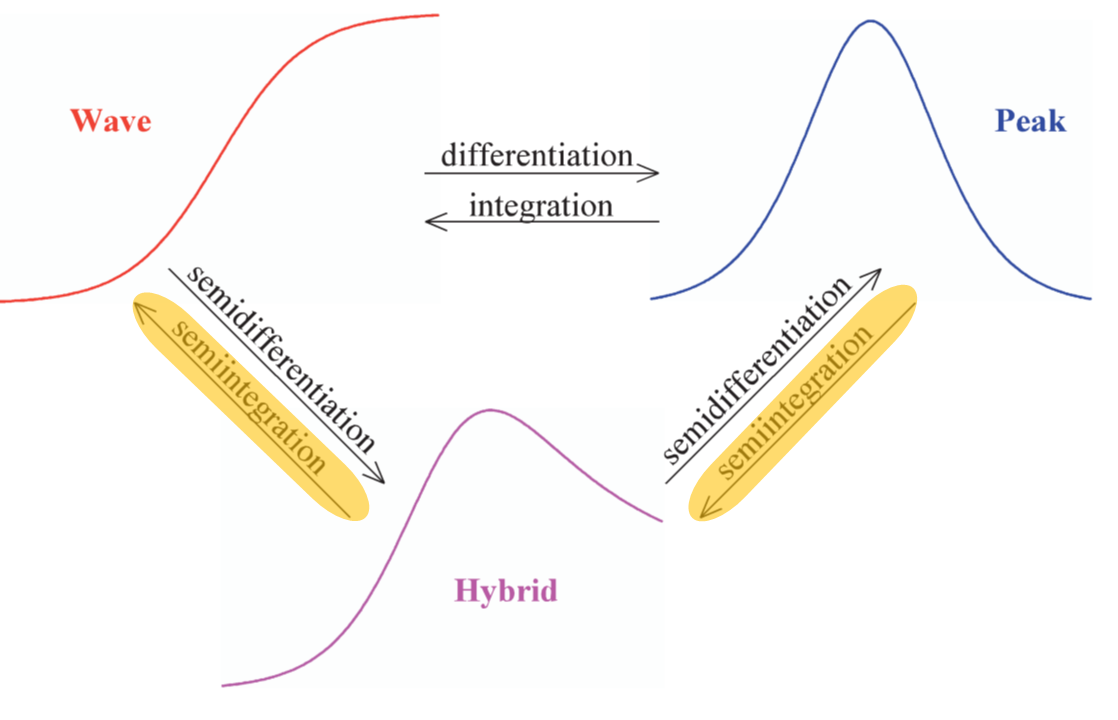

# 3 Semiintegration Methods
Now we introduce some methods to apply the semiintegration. These work in generall with discrete values, i.e. the function graph (like above) has to be seperated into discrete finite values:

$$
\begin{align}
f(0), f(\delta), ..., f((N-1)\delta), f(N\delta)
\end{align}
$$

Here we assume that the step size $\delta$ is equidistant, meaning for a fixed set of x-Values $N$:

$$
\begin{align}
\delta = \frac{x_N}{N}
\end{align}
$$


## 3.1 Grünwald Algorithms
The Grünwald Algorithm are probably the most simplest algorithm from 1867 (Grünwald, A.K. Uber *"begrenzte" Derivationen und deren Anwendungen der Integration und Differentiation.* In Z. Angew. Math. und Phys. 1867, 12, 441-480). It can be generally expressed by taking the sum of the discrete function values multiplied with weights $w_i$ and then divided by the stepsize:

$$
\begin{align}
\frac{d^{\pm 0.5}}{dt^{\pm 0.5}} f(t) =\frac{1}{\delta^{\pm 0.5}} \sum_{n=0}^{N-1} w_n f(n\delta)
\end{align}
$$

The G1 algorithms are ideal for voltammograms like linear-scan or cyclic versions, where the early signals are small.\
**Note**, that these algorithms are less suitable for step and pulse varieties, in which the initial currents are large.

The weight can be expressed on different ways, often the single weights $w_i$ depends on their predecessor $w_{i-1}$. As the factorial expression could lead to an overflow, this algorithm can by simplified, like in the following.


The **Grünwald G1 Semiintegration Algorithm** is defined as follows:

$$
\begin{align}
\frac{d^{- 0.5}}{dt^{- 0.5}} f(t) \approx \sqrt{\delta} \sum_{n=1}^{N} w_{N-n} f(n\delta)
\end{align}
$$

Which can be also displayed in reverse summation (like in the implementation):

$$
\begin{align}
\frac{d^{- 0.5}}{dt^{- 0.5}} f(t) \approx \sqrt{\delta} \sum_{n=N}^{1} w_{N-n} f(n\delta)
\end{align}
$$

With:
* $w_0 = 1$
* $w_n = \frac{(n-0.5)w_{n-1}}{n} = (1-\frac{0.5}{n})w_{n-1}$

In [10]:
# exemplary implementation
def G1_Semiint(I,t):
    # (equidistant) time step
    delta = t[1]-t[0]
    # No. of steps
    N_max = I.size
    # initialize with zeros
    G1 = np.zeros(N_max)

    sqr_d = np.sqrt(delta)
    
    for N in range(1,N_max+1):
        # value for n = N with w0 = 1
        G1_i = I[0]; 
        #      go from N to 0
        for n in range(N-1,0,-1):

            G1_i = G1_i*(1-(0.5)/n) + I[N-n]
            
        G1[N-1] = G1_i*sqr_d
    return(G1)

Now this function is tested by comparing the result of twice application of G1 semiintegration with a full cumulative trapezoidal integration on two test cases:
1. With a simple linear graph ($y = 1$)
2. With the previously derived current function of a steady-state voltammogram

In [51]:
# test with a simple linear graph (y = 1)
mysize = 1000
y = np.array([1]*mysize)
x = np.linspace(0,1000, mysize)

delta_x = x[1] - x[0]
# G1 alg. from above
d1 = G1_Semiint(G1_Semiint(y,x), x)
# implemented alg
%run ../ec_tools/semi_integration/G1.py 
d_alg = semi_integration(semi_integration(y, x,),x)
# ref
d2 = cumulative_trapezoid(y,x)


error = (np.abs(d1[:-1]-d2))
error_alg = (np.abs(d_alg[:-1]-d2))
err_rel = error/np.abs(d2)

print('double G1 values:',d1[0:4])
print('double G1 values:',d_alg[0:4])
print(' cum trap values:',d2[0:4],'\n')

print('abs error:',max(error))
print('rel error:',max(err_rel))


# verification in one line
#np.allclose(G1_Semiint(G1_Semiint(y,x), x)[:-1], cumulative_trapezoid(y,x,initial=0)[1:], rtol=2.5e-03)

double G1 values: [1.001001 2.002002 3.003003 4.004004]
double G1 values: [1.001001  2.002002  2.5025025 2.669336 ]
 cum trap values: [1.001001 2.002002 3.003003 4.004004] 

abs error: 3.183231456205249e-12
rel error: 3.4262291328102225e-15


double G1 values: [3.60363364e-06 7.27807969e-06 1.10247295e-05 1.48450019e-05]
 cum trap values: [3.63903985e-06 7.34958779e-06 1.11330489e-05 1.49908559e-05] 

abs error: 0.030308122017917327
rel error: 0.009729545024792272


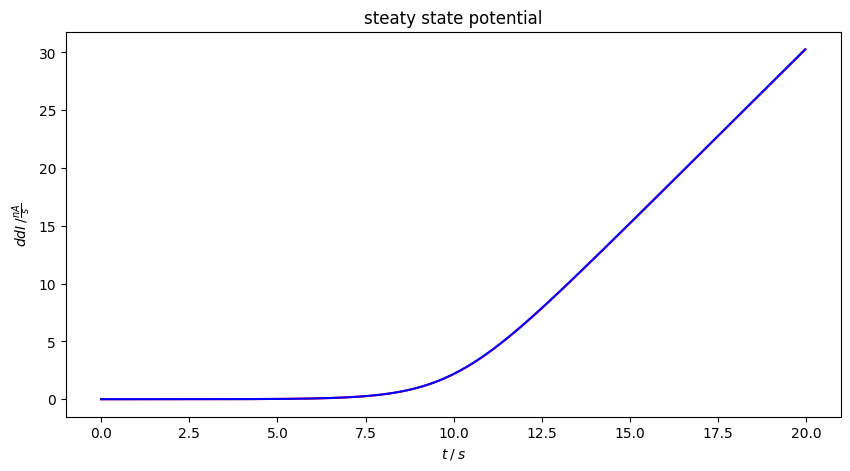

In [31]:
# Test with the previously derived current function of a steady-state voltammogram
N_max = 1000;   # No. of time intervals

# calculate potential
[t,I] = current_hemispherical1(N_max =N_max); # with default values

# calculate double semiintegral
dI  = G1_Semiint(I,t)
ddI = G1_Semiint(dI,t)

# compare with numerical integration
d2 = cumulative_trapezoid(I,t)

error = np.abs(ddI[:-1]-d2)
err_rel = error/np.abs(d2)

print('double G1 values:',ddI[0:4])
print(' cum trap values:',d2[0:4],'\n')

print('abs error:',max(error))
print('rel error:',max(err_rel))

# Plot the current for different scan rates
plt.plot(t,ddI,'r')
plt.plot(t[:-1],d2,'b')
plt.ylabel('$ddI\: / \\frac{nA}{s}$')
plt.xlabel('$t\: / \:s$')
plt.title('steaty state potential')
plt.show()

The Grünwald definition can also be applied as the **Grünwald G1 Semidifferentiation Algorithm** by:

$$
\begin{align}
\frac{d^{0.5}}{dt^{0.5}} f(t) \approx \frac{1}{\sqrt{\delta}} \sum_{n=0}^{N-1} w_{N-n} f(n\delta)
\end{align}
$$
With:
* $w_0 = 1$
* $w_n = \frac{(n-1.5)w_{n-1}}{n}$

In [21]:
def G1_Semidiff(I,t):
    # (equidistant) time step
    delta = t[1]-t[0]
    # No. of steps
    N_max = I.size
    # initialize with zeros
    G1 = np.zeros(N_max)
    for N in range(0,N_max):
        # value for n = N with w0 = 1
        G1_i = I[0]; 
        #      go from N to 0
        for n in range(N,0,-1):
            #print(n-1)
            G1_i = G1_i*((n)-1.5)/(n) + I[N-n+1]
        G1[N] = G1_i/np.sqrt(delta)
    return(G1)

## 3.2 RL Algorithms

Based on the Riemann and Liouville definitions, these sort of algorithms are mainly straightforward general-purpose algorithms and have their first origin in 1892 by Riemann, B. et al. in *Versuch einer allgemeinen Auffassung der Integration und Differentiation*, Gesammelte Werke, published posthumously, Teubner, Leipzig, pp. 353-366.

The algorithm (from $\texttt{Web1242}$) for the **R1 semiintegration** is:
$$
\begin{align}
\frac{d^{-1/2}}{dt^{-1/2}}f(t)&=\\
&\frac{4}{3} \sqrt{\frac{\delta}{\pi}} \left[ f(N\delta) + \left\{ \frac{3}{2}\sqrt{N} - N^{3/2} + (N-1)^{3/2} \right\}f(0) +
  \sum_{n=1}^{N-1} \left\{ (N-n+1)^{3/2} - 2 (N-n)^{3/2} + (N-n-1)^{3/2} \right\}f(n\delta) \right]
\end{align}
$$

The R1 algorithms are not usable for application to currents that arise from potential steps or leaps [Oldham], as:
- the large current at $t=0$, immediately following the step is impossible to measure accurately and even if it would be possible, it is likely to be largely composed of a chemically uninteresting nonfaradaic component. But the algorithm still require a value of $f(0)$.
- the algorithm is based on the assumption that $f(t)$ can be treated as an assemblage of linear segments, whereas faradaic currents arising from a potential step and are decidedly nonlinear with time. 

In [22]:
def R1_Semiint(I,t):
    delta = t[1] - t[0]
    # No. of steps
    N_max = I.size
    # initialize with zeros
    R1 = np.zeros(N_max)

    for N in range(1,N_max+1):
        R1_i = 0
        for n in range(1,N):
            R1_i += I[n-1]*((N-n+1)**(3/2) - 2*(N-n)**(3/2) + (N-n-1)**(3/2))
            
        R1[N-1] = (4/3)*np.sqrt(delta/np.pi)*(I[N-1] + I[0]*(1.5*np.sqrt(N)-N**(3/2) + (N-1)**(3/2)) + R1_i)
    
    return(R1)

double R1 values: [1.27451406 2.15438241 3.12109186 4.10379538]
 cum trap values: [1.001001 2.002002 3.003003 4.004004] 

abs error: 0.2735130577929552
rel error: 0.2732395447351622


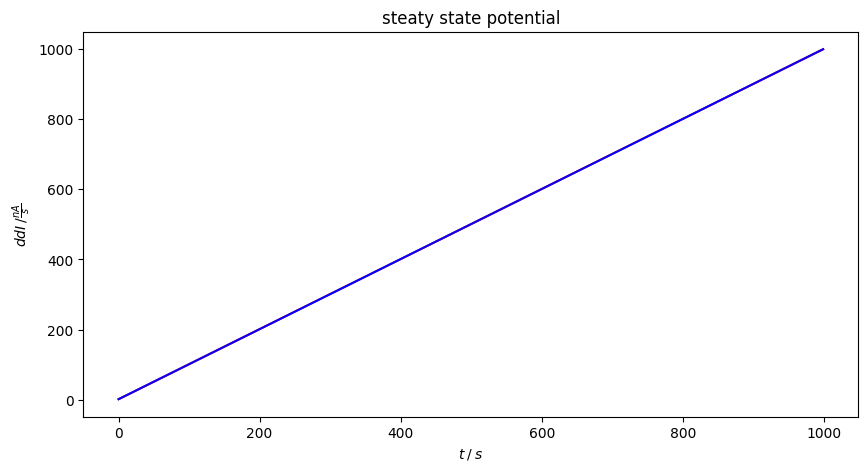

In [35]:
mysize = 1000
I = np.array([1]*mysize)
t = np.linspace(0,1000, mysize)
        
# calculate double semiintegral
dI_R1  = R1_Semiint(R1_Semiint(I,t),t)
ddI_R1 = dI_R1[:-1]

# compare with numerical integration
d2 = cumulative_trapezoid(I,t)
error = np.abs(ddI_R1-d2)
err_rel = error/np.abs(d2)

print('double R1 values:',ddI_R1[0:4])
print(' cum trap values:',d2[0:4],'\n')

print('abs error:',max(error))
print('rel error:',max(err_rel))

#case = np.allclose(R1_Semiint1(R1_Semiint1(I,t), t)[:-1], cumulative_trapezoid(I,t), rtol=1e-1)

# Plot the current for different scan rates
plt.plot(t[:-1],ddI_R1,'r')
plt.plot(t[:-1],d2,'b')
plt.ylabel('$ddI\: / \\frac{nA}{s}$')
plt.xlabel('$t\: / \:s$')
plt.title('steaty state potential')
plt.show()

double R1 values: [4.58828886e-06 7.79591294e-06 1.13833478e-05 1.51011911e-05]
 cum trap values: [3.63903985e-06 7.34958779e-06 1.11330489e-05 1.49908559e-05] 

abs error: 0.06061611666151734
rel error: 0.2608515032573159


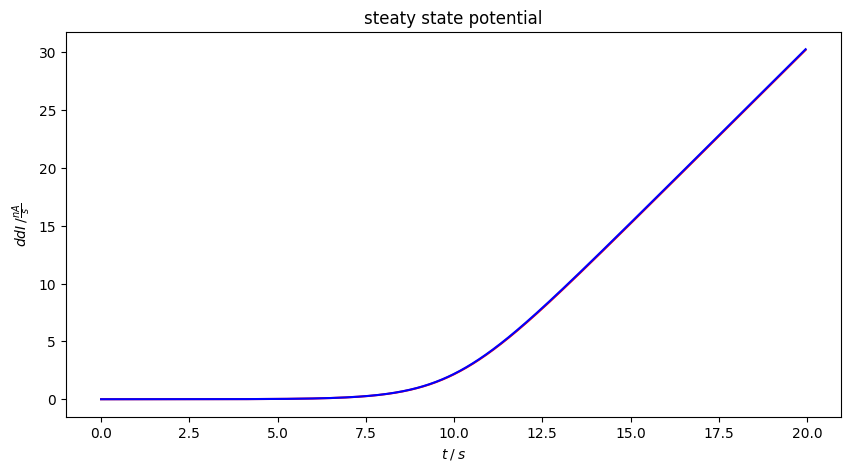

In [36]:
#mysize = 1000
#I = np.array([1]*mysize)
#t = np.linspace(0,1000, mysize)
        
N_max = 1000;   # No. of time intervals
[t,I] = current_hemispherical1(N_max =N_max); # with default values

# calculate double semiintegral
dI_R1  = R1_Semiint(R1_Semiint(I,t),t)
ddI_R1 = dI_R1[:-1]

# compare with numerical integration
d2 = cumulative_trapezoid(I,t)
error = np.abs(ddI_R1-d2)
err_rel = error/np.abs(d2)

print('double R1 values:',ddI_R1[0:4])
print(' cum trap values:',d2[0:4],'\n')

print('abs error:',max(error))
print('rel error:',max(err_rel))

#case = np.allclose(R1_Semiint1(R1_Semiint1(I,t), t)[:-1], cumulative_trapezoid(I,t), rtol=1e-1)

# Plot the current for different scan rates
plt.plot(t[:-1],ddI_R1,'r')
plt.plot(t[:-1],d2,'b')
plt.ylabel('$ddI\: / \\frac{nA}{s}$')
plt.xlabel('$t\: / \:s$')
plt.title('steaty state potential')
plt.show()

The general definition for the **R1 semidifferentiation** is defined by:

$$
\begin{align}
\frac{d^{1/2}}{dt^{1/2}}f(t)&=\\
&\frac{2}{\sqrt{\pi\delta}} \left[ f(N\delta) + \left\{ \frac{1}{2\sqrt{N}} - \sqrt{N} + \sqrt{N-1}\right\}f(0) +
  \sum_{n=1}^{N-1} \left\{ \sqrt{N-n+1} - 2 \sqrt{N-n} + \sqrt{N-n-1} \right\}f(n\delta) \right]
\end{align}
$$

In [41]:
def R1_Semidiff(I,t):
    delta = t[1] - t[0]
    # No. of steps
    N_max = I.size
    # initialize with zeros
    R1 = np.zeros(N_max)

    for N in range(1,N_max+1):
        R1_i = 0
        for n in range(1,N):
            R1_i += I[n-1]*(np.sqrt(N-n+1) - 2*np.sqrt(N-n) + np.sqrt(N-n-1))
            
        R1[N-1] = (2/np.sqrt(np.pi*delta))*(I[N-1] + I[0]*(1/(2*np.sqrt(N)) - np.sqrt(N) + np.sqrt(N-1)) + R1_i)
    
    return(R1)    

# Comparison of G1 and R1

difference with first run
0.0020640284290374122
difference with second run
0.0061475449749391585


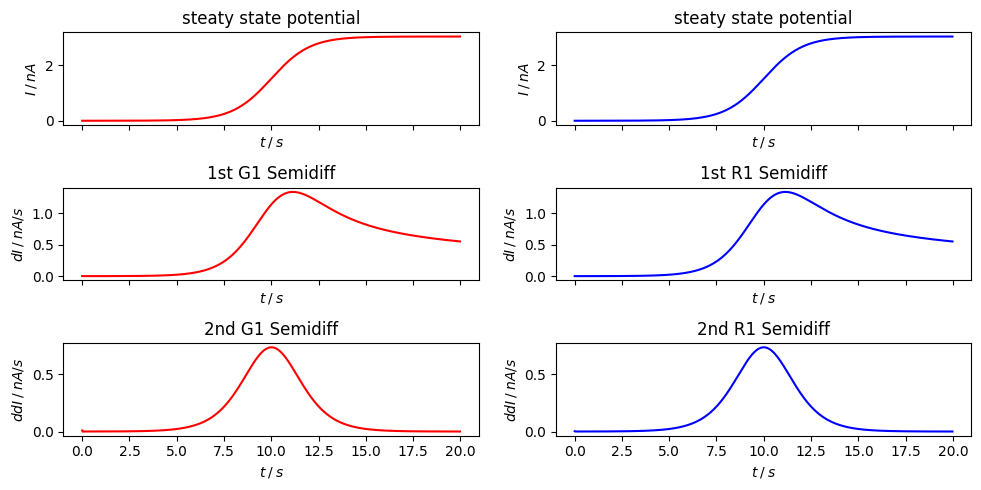

In [42]:
N_max = 1001;   # No. of time intervals

# calculate potential
[t,I] = current_hemispherical1(N_max =N_max); # with default values

# Grünwald
dI_G1  = G1_Semidiff(I,t)
ddI_G1 = G1_Semidiff(dI_G1,t)

# RL
dI_R1  = R1_Semidiff(I,t)
ddI_R1 = R1_Semidiff(dI_R1,t)

error_d1 = max((np.abs( dI_R1 -  dI_G1)))
error_d2 = max((np.abs(ddI_R1 - ddI_G1)))

print('difference with first run')
print(error_d1)
print('difference with second run')
print(error_d2)


## Plot results
fig, ax = plt.subplots(nrows=3, ncols=2, sharex = True)
## G1

ax[0][0].plot(t,I,'r')
ax[0][0].set_ylabel('$I\: / \:nA$')
ax[0][0].set_xlabel('$t\: / \:s$')
ax[0][0].set_title('steaty state potential')

ax[1][0].plot(t,dI_G1,'r')
ax[1][0].set_ylabel('$dI\: / \:nA/s$')
ax[1][0].set_xlabel('$t\: / \:s$')
ax[1][0].set_title('1st G1 Semidiff')

ax[2][0].plot(t,ddI_G1,'r')
ax[2][0].set_ylabel('$ddI\: / \:nA/s$')
ax[2][0].set_xlabel('$t\: / \:s$')
ax[2][0].set_title('2nd G1 Semidiff')

## R1

ax[0][1].plot(t,I,'b')
ax[0][1].set_ylabel('$I\: / \:nA$')
ax[0][1].set_xlabel('$t\: / \:s$')
ax[0][1].set_title('steaty state potential')

ax[1][1].plot(t,dI_R1,'b')
ax[1][1].set_ylabel('$dI\: / \:nA/s$')
ax[1][1].set_xlabel('$t\: / \:s$')
ax[1][1].set_title('1st R1 Semidiff')

ax[2][1].plot(t,ddI_R1,'b')
ax[2][1].set_ylabel('$ddI\: / \:nA/s$')
ax[2][1].set_xlabel('$t\: / \:s$')
ax[2][1].set_title('2nd R1 Semidiff')

fig.tight_layout()